## Setup and Imports

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import traceback
import warnings
from scipy.linalg import eigvals, eigvalsh, LinAlgError
from scipy.sparse import issparse

# Add paths
sys.path.append('.')
sys.path.append('..')

# Import our modules
from robust_testing import RobustTester, ParameterGenerator, TestResult, FailureType
from pli_profiling import run_with_dependencies
from pygeoinf.linear_solvers import LUSolver

print("✅ All imports successful!")

# Configure plotting
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("husl")

✅ All imports successful!


## Phase 1: Systematic Failure Reproduction

Let's start by creating a controlled test environment to reproduce the covariance matrix failures.

In [36]:
# Base parameters - start with known working configuration
base_params = {
    'N': 20,
    'N_d': 20,
    'N_p': 5,
    'endpoints': (0, 1),
    'basis_type': 'sine',
    'integration_method_G': 'trapz',
    'integration_method_T': 'trapz',
    'n_points_G': 500,
    'n_points_T': 500,
    'alpha': 0.1,
    'K': 50,
    'true_data_noise': 0.1,
    'assumed_data_noise': 0.1,
    'm_bar_callable': lambda x: np.sin(2 * np.pi * x),
    'm_0_callable': lambda x: np.zeros_like(x),
    'solver': LUSolver()
}

print("🎯 Base parameters configured")
print(f"Problem size: N={base_params['N']}, N_d={base_params['N_d']}, N_p={base_params['N_p']}")

🎯 Base parameters configured
Problem size: N=20, N_d=20, N_p=5


## Using the New Custom Test Suite

The `robust_testing.py` module now includes a `run_custom_test_suite()` method that lets you provide your own list of configurations and get back a structured DataFrame. This is perfect for targeted investigations!

In [37]:
# Example 1: Custom configurations for targeted investigation
from robust_testing import run_custom_robustness_test

# Define specific configurations we want to test
# Focus on problematic parameter ranges we identified
custom_configs = []
N_min, N_max = 10, 100
N_d_min, N_d_max = 10, 100
N_p_min, N_p_max = 1, 30
# Test cases around the borderline where failures happen
cases = [{'N': int(N), 'N_d': int(N_d), 'N_p': int(N_p)}
         for N in np.linspace(N_min, N_max, num=5)
         for N_d in np.linspace(N_d_min, N_d_max, num=5)
         for N_p in np.linspace(N_p_min, N_p_max, num=5)]

custom_configs = [base_params | base_config for base_config in cases]
print(f"Created {len(custom_configs)} custom test configurations")
print("Sample config:", custom_configs[0])

Created 125 custom test configurations
Sample config: {'N': 10, 'N_d': 10, 'N_p': 1, 'endpoints': (0, 1), 'basis_type': 'sine', 'integration_method_G': 'trapz', 'integration_method_T': 'trapz', 'n_points_G': 500, 'n_points_T': 500, 'alpha': 0.1, 'K': 50, 'true_data_noise': 0.1, 'assumed_data_noise': 0.1, 'm_bar_callable': <function <lambda> at 0x7f5765e2de40>, 'm_0_callable': <function <lambda> at 0x7f5765ebaca0>, 'solver': <pygeoinf.linear_solvers.LUSolver object at 0x7f5765da6610>}


In [38]:
# Run the custom test suite - this returns a DataFrame!
results_df = run_custom_robustness_test(
    configurations=custom_configs,
    save_to_file='custom_covariance_investigation.csv',  # Save results
    timeout_seconds=60,
    verbose=True
)

print("\n📊 RESULTS DATAFRAME:")
print(f"Shape: {results_df.shape}")
print("\nColumns:")
print(results_df.columns.tolist())
print("\nFirst few rows:")
print(results_df.head())

🧪 Running Custom Test Suite with 125 configurations...
Running test 1/125...
Executing setup_spatial_spaces...
Executing setup_mappings...
Executing _setup_truths_and_measurement...
Executing setup_prior_measure...
LaplacianInverseOperator initialized with native solver, dirichlet(left=0, right=0) BCs
Executing create_problems...
Executing compute_property_posterior...
✅ SUCCESS: 0.24s
Running test 2/125...
Executing setup_spatial_spaces...
Executing setup_mappings...
Executing _setup_truths_and_measurement...
Executing setup_prior_measure...
LaplacianInverseOperator initialized with native solver, dirichlet(left=0, right=0) BCs
Executing create_problems...
Executing compute_property_posterior...
✅ SUCCESS: 0.64s
Running test 3/125...
Executing setup_spatial_spaces...
Executing setup_mappings...
Executing _setup_truths_and_measurement...
Executing setup_prior_measure...
LaplacianInverseOperator initialized with native solver, dirichlet(left=0, right=0) BCs
Executing create_problems...


In [39]:
# Analyze the DataFrame - this is much easier than the old format!
print("🔍 ANALYSIS OF CUSTOM TEST RESULTS:")

# Basic statistics
success_rate = results_df['success'].mean()
print(f"\nOverall success rate: {success_rate:.1%}")

# Look at failures by parameter ranges
failed_tests = results_df[~results_df['success']]
if len(failed_tests) > 0:
    print(f"\nFailed tests: {len(failed_tests)}")
    print("Failure types:")
    print(failed_tests['failure_type'].value_counts())

    print("\nFailed parameter ranges:")
    print("N range:", failed_tests['param_N'].min(), "to", failed_tests['param_N'].max())
    print("N_d range:", failed_tests['param_N_d'].min(), "to", failed_tests['param_N_d'].max())
    print("N_p range:", failed_tests['param_N_p'].min(), "to", failed_tests['param_N_p'].max())

# Look at execution times
print(f"\nExecution time stats:")
print(f"Mean: {results_df['execution_time'].mean():.2f}s")
print(f"Max: {results_df['execution_time'].max():.2f}s")
print(f"Min: {results_df['execution_time'].min():.2f}s")

# Show a few example rows
print("\n📋 Sample successful tests:")
successful = results_df[results_df['success']].head(3)
print(successful[['param_N', 'param_N_d', 'param_N_p', 'param_true_data_noise', 'execution_time']])

🔍 ANALYSIS OF CUSTOM TEST RESULTS:

Overall success rate: 44.0%

Failed tests: 70
Failure types:
failure_type
numerical_instability    70
Name: count, dtype: int64

Failed parameter ranges:
N range: 10 to 100
N_d range: 10 to 100
N_p range: 15 to 30

Execution time stats:
Mean: 4.18s
Max: 12.41s
Min: 0.23s

📋 Sample successful tests:
   param_N  param_N_d  param_N_p  param_true_data_noise  execution_time
0       10         10          1                    0.1        0.236806
1       10         10          8                    0.1        0.637339
5       10         32          1                    0.1        0.714839


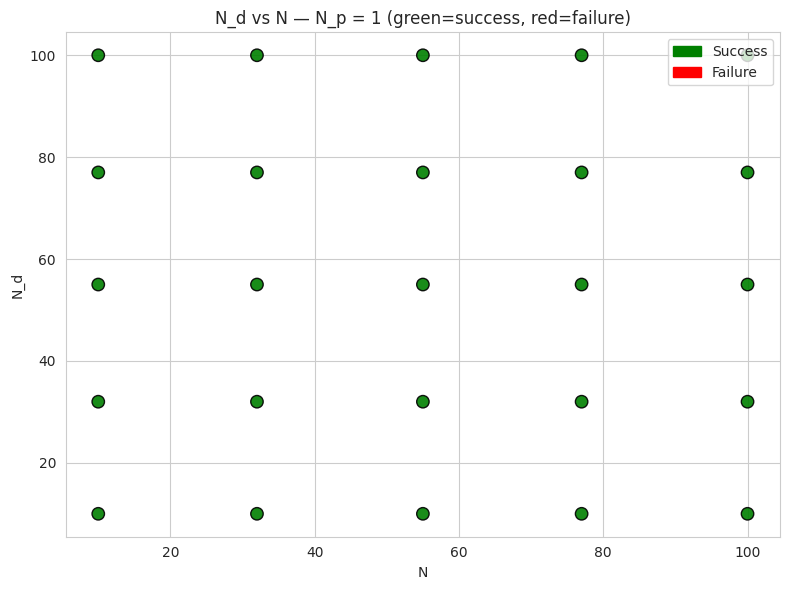

Total rows for N_p=1: 25
Succeeded: 25, Failed: 0, Unknown: 0


In [50]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

# --- Configure: set the N_p value you want to inspect ---
chosen_N_p = 1

# --- Load DataFrame: prefer in-memory results_df, fallback to df or CSV ---
if 'results_df' in globals():
    df = results_df.copy()
elif 'df' in globals():
    df = df.copy()
else:
    csv_path = 'custom_covariance_investigation.csv'
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"Neither results_df nor df found in memory and {csv_path} does not exist.")
    df = pd.read_csv(csv_path, low_memory=False)

# --- Basic checks ---
required = ['param_N', 'param_N_d', 'param_N_p', 'success']
missing = [c for c in required if c not in df.columns]
if missing:
    raise KeyError(f"Missing required columns in DataFrame: {missing}")

# --- Normalize types ---
for c in ['param_N', 'param_N_d', 'param_N_p']:
    df[c] = pd.to_numeric(df[c], errors='coerce')

def to_bool(x):
    if pd.isna(x):
        return None
    if isinstance(x, bool):
        return x
    if isinstance(x, (int, float)):
        try:
            return bool(int(x))
        except Exception:
            return None
    s = str(x).strip().lower()
    if s in ('true','t','1','yes','y'):
        return True
    if s in ('false','f','0','no','n'):
        return False
    return None

df['success_bool'] = df['success'].apply(to_bool)

# --- Filter by chosen N_p ---
subset = df[df['param_N_p'] == chosen_N_p].copy()
if subset.empty:
    print(f"No rows found for param_N_p == {chosen_N_p}. Available values:\n{sorted(df['param_N_p'].dropna().unique())}")
else:
    # color mapping
    colors = subset['success_bool'].map({True: 'green', False: 'red'}).fillna('gray')

    # Plot
    sns.set_style('whitegrid')
    plt.figure(figsize=(8, 6))
    plt.scatter(subset['param_N'], subset['param_N_d'], c=colors, s=80, edgecolors='k', alpha=0.9)
    plt.xlabel('N')
    plt.ylabel('N_d')
    plt.title(f'N_d vs N — N_p = {chosen_N_p} (green=success, red=failure)')

    # Legend
    handles = [mpatches.Patch(color='green', label='Success'),
               mpatches.Patch(color='red', label='Failure')]
    if subset['success_bool'].isna().any():
        handles.append(mpatches.Patch(color='gray', label='Unknown'))
    plt.legend(handles=handles)
    plt.tight_layout()
    plt.show()

    # Summary
    n_total = len(subset)
    n_succeeded = int((subset['success_bool'] == True).sum())
    n_failed = int((subset['success_bool'] == False).sum())
    n_unknown = int(subset['success_bool'].isna().sum())
    print(f"Total rows for N_p={chosen_N_p}: {n_total}")
    print(f"Succeeded: {n_succeeded}, Failed: {n_failed}, Unknown: {n_unknown}")

    if n_failed > 0:
        print("\nSample failing configurations:")
        display_cols = ['param_N', 'param_N_d', 'param_N_p', 'failure_type', 'error_message']
        available = [c for c in display_cols if c in subset.columns]
        print(subset[subset['success_bool'] == False][available].head(10).to_string(index=False))

In [1]:
# Interactive slider to pick N_p and replot N_d vs N (green=success, red=failure)
import pandas as pd
import os
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

# Reuse same DataFrame-loading logic as earlier cells (prefer in-memory objects)
if 'results_df' in globals():
    df = results_df.copy()
elif 'df' in globals():
    df = df.copy()
else:
    csv_path = 'custom_covariance_investigation.csv'
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f'Neither results_df nor df found in memory and {csv_path} does not exist.')
    df = pd.read_csv(csv_path, low_memory=False)

# Ensure required column exists
if 'param_N_p' not in df.columns:
    raise KeyError('param_N_p column not found in DataFrame')

# Build list of available N_p values (integers when possible)
unique_Np = sorted(pd.to_numeric(df['param_N_p'], errors='coerce').dropna().unique())
if len(unique_Np) == 0:
    print('No available N_p values to select')
else:
    # if values are integral, cast to int for nicer slider labels
    if all(float(x).is_integer() for x in unique_Np):
        unique_Np = [int(x) for x in unique_Np]
    slider = widgets.SelectionSlider(options=unique_Np, value=unique_Np[0], description='N_p', continuous_update=False, layout=widgets.Layout(width='80%'))
    out = widgets.Output()

    def to_bool(x):
        if pd.isna(x):
            return None
        if isinstance(x, bool):
            return x
        try:
            # numeric-like
            return bool(int(x))
        except Exception:
            s = str(x).strip().lower()
            if s in ('true','t','1','yes','y'):
                return True
            if s in ('false','f','0','no','n'):
                return False
        return None

    def plot_for(N_p):
        with out:
            clear_output(wait=True)
            subset = df[df['param_N_p'] == N_p].copy()
            if subset.empty:
                print(f'No rows for N_p={N_p}')
                return
            for c in ['param_N','param_N_d']:
                subset[c] = pd.to_numeric(subset[c], errors='coerce')
            subset['success_bool'] = subset['success'].apply(to_bool)
            colors = subset['success_bool'].map({True: 'green', False: 'red'}).fillna('gray')
            sns.set_style('whitegrid')
            plt.figure(figsize=(8,6))
            plt.scatter(subset['param_N'], subset['param_N_d'], c=colors, s=80, edgecolors='k', alpha=0.9)
            plt.xlabel('N')
            plt.ylabel('N_d')
            plt.title(f'N_d vs N — N_p = {N_p} (green=success, red=failure)')
            handles = [mpatches.Patch(color='green', label='Success'), mpatches.Patch(color='red', label='Failure')]
            if subset['success_bool'].isna().any():
                handles.append(mpatches.Patch(color='gray', label='Unknown'))
            plt.legend(handles=handles)
            plt.tight_layout()
            plt.show()
            n_total = len(subset)
            n_succeeded = int((subset['success_bool'] == True).sum())
            n_failed = int((subset['success_bool'] == False).sum())
            n_unknown = int(subset['success_bool'].isna().sum())
            print(f'Total rows for N_p={N_p}: {n_total}')
            print(f'Succeeded: {n_succeeded}, Failed: {n_failed}, Unknown: {n_unknown}')

    display(slider, out)
    slider.observe(lambda change: plot_for(change['new']), names='value')
    plot_for(slider.value)

/home/users/scro4564/anaconda3/envs/inferences2/lib/python3.11/site-packages/seaborn/_statistics.py:32: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.2)
  from scipy.stats import gaussian_kde


/home/users/scro4564/anaconda3/envs/inferences2/lib/python3.11/site-packages/seaborn/_statistics.py:32: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.2)
  from scipy.stats import gaussian_kde


SelectionSlider(continuous_update=False, description='N_p', layout=Layout(width='80%'), options=(1, 8, 15, 22,…

Output()